In [1]:
import math
import pickle as pkl
import re

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from tqdm import tqdm

**Utilities**

In [2]:
def remove_double_commas(text):
    """
    Removes double commas from the given text.

    Args:
    text (str): The input string with potential double commas.

    Returns:
    str: The processed string with double commas replaced by a single comma.
    """
    # Define the pattern to match double commas
    pattern = r",,"

    # Use re.sub to replace double commas with a single comma
    cleaned_text = re.sub(pattern, ",", text)

    # Return the cleaned text
    return cleaned_text


def pad_sequence(sequence, max_len):
    """
    Pads the given sequence to the specified maximum length.

    Args:
    sequence (list): The input sequence to pad.
    max_len (int): The maximum length to pad the sequence to.

    Returns:
    list: The padded sequence.
    """
    # Calculate the padding length
    pad_len = max_len - len(sequence) - 1

    # Pad the sequence with zeros
    padded_sequence = [0] + sequence + [15] * pad_len

    # Return the padded sequence
    return padded_sequence

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

**Model implementation**

In [4]:
# class Mlp(nn.Module):
#     def __init__(
#         self,
#         in_features,
#         hidden_features=None,
#         out_features=None,
#         act_layer=nn.GELU,
#         drop_rate=0.0,
#     ):
#         super().__init__()
#         self.drop_rate = drop_rate
#         out_features = out_features or in_features
#         hidden_features = hidden_features or in_features
#         self.fc1 = nn.Linear(in_features, hidden_features)
#         self.act = act_layer()
#         self.fc2 = nn.Linear(hidden_features, out_features)
#         if self.drop_rate > 0.0:
#             self.drop = nn.Dropout(drop_rate)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.act(x)
#         if self.drop_rate > 0.0:
#             x = self.drop(x)
#         x = self.fc2(x)
#         if self.drop_rate > 0.0:
#             x = self.drop(x)
#         return x

# class TransformerDecoder(nn.Module):
#     def __init__(
#         self,
#         input_dim,
#         d_model,
#         nhead,
#         num_layers,
#         dim_feedforward,
#         num_classes,
#         max_len=25,
#         sos_token=14,
#         eos_token=15,
#         pad_token=-1,
#     ):
#         super(TransformerDecoder, self).__init__()
#         # SOS, EOS, and PAD tokens
#         self.SOS_TOKEN = sos_token
#         self.EOS_TOKEN = eos_token
#         self.PAD_TOKEN = pad_token

#         self.embedding_layer = Mlp(
#             in_features=input_dim, out_features=d_model
#         )  # [b, s, c] -> [b, s, d]
#         self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
#         decoder_layer = nn.TransformerDecoderLayer(
#             d_model, nhead, dim_feedforward, dropout=0.1, batch_first=True
#         )
#         self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
#         self.output_layer = nn.Linear(d_model, num_classes)

#     def forward(self, src, tgt):  # [b, n] -> [b, t, c]
#         src = self.embedding_layer(src)
#         tgt = tgt.reshape(tgt.size(0), tgt.size(1), -1)  # [b, t, 1]

#         """
#         # Add SOS and EOS tokens
#         for i in range(tgt.size(0)):
#             for j in range(tgt.size(1) - 1, 0, -1):
#                 tgt[i, j, 0] = tgt[i, j - 1, 0]
#         tgt[:, 0, 0] = self.SOS_TOKEN

#         for i in range(tgt.size(0)):
#             for j in range(tgt.size(1)):
#                 if tgt[i, j, 0] == self.PAD_TOKEN:
#                     tgt[i, j, 0] = self.EOS_TOKEN
#                     break
#         """

#         # Generate mask
#         tgt_key_padding_mask = tgt.squeeze(-1) == -1

#         # Add positional encoding
#         tgt = self.pos_encoder(tgt)

#         output = self.transformer_decoder(
#             tgt, src, tgt_key_padding_mask=tgt_key_padding_mask
#         )
#         logits = self.output_layer(output)
#         return logits

**Process feats into dataset**

In [5]:
import pandas as pd

with open(
    "../model=slow-50-tap/model=slow-50_method=tap4x8_ext=manifold_mixup_triplets_train_feats.pkl",
    "rb",
) as f:
    train_data = pkl.load(f)

with open(
    "../model=slow-50-tap/model=slow-50_method=tap4x8_ext=manifold_mixup_triplets_val_feats.pkl",
    "rb",
) as f:
    val_data = pkl.load(f)

metadata = pd.read_csv(
    "/home/dl18206/Desktop/phd/data/panaf/PanAfFull/notebooks/data/panaf-seq_metadata.csv"
)

with open("../data/behaviours.txt", "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

behaviours_dict = {beh: i for i, beh in enumerate(behaviours)}

In [6]:
max_seq_len = 25

# Get the names of the clips
train_name_df = pd.DataFrame(train_data["names"], columns=["name"])
val_name_df = pd.DataFrame(val_data["names"], columns=["name"])

train_name_df = train_name_df.merge(
    metadata[["subject_id", "value"]], left_on="name", right_on="subject_id"
).drop(columns=["subject_id"])

val_name_df = val_name_df.merge(
    metadata[["subject_id", "value"]], left_on="name", right_on="subject_id"
).drop(columns=["subject_id"])


train_name_df["value"] = train_name_df["value"].apply(lambda x: remove_double_commas(x))
val_name_df["value"] = val_name_df["value"].apply(lambda x: remove_double_commas(x))


train_name_df["sequence"] = train_name_df["value"].apply(
    lambda x: (
        [behaviours_dict[i] for i in x.split(",")]
        if "" not in x.split(",")
        else behaviours_dict[x]
    )
)

val_name_df["sequence"] = val_name_df["value"].apply(
    lambda x: (
        [behaviours_dict[i] for i in x.split(",")]
        if "" not in x.split(",")
        else behaviours_dict[x]
    )
)

train_name_df["sequence"] = train_name_df["sequence"].apply(
    lambda x: pad_sequence(x, max_seq_len)
)
val_name_df["sequence"] = val_name_df["sequence"].apply(
    lambda x: pad_sequence(x, max_seq_len)
)

# Add the imported names and sequences to data
train_data["imported_name"] = train_name_df["name"].values
train_data["sequence"] = train_name_df["sequence"].values

val_data["imported_name"] = val_name_df["name"].values
val_data["sequence"] = val_name_df["sequence"].values

# Check indexing is correct
for n1, n2 in zip(train_data["imported_name"], train_data["names"]):
    assert n1 == n2, f"{n1} != {n2}"

for n1, n2 in zip(val_data["imported_name"], val_data["names"]):
    assert n1 == n2, f"{n1} != {n2}"

In [7]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        max_seq_length,
        vocab_size,
        dropout=0.1,
    ):
        super(TransformerEncoderDecoder, self).__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size
        self.sos_token = 0  # Start of Sequence token
        self.pad_token = 15  # Padding token
        self.max_seq_length = max_seq_length

        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_decoder_layers
        )

        self.output_projection = nn.Linear(d_model, vocab_size)
        self.tgt_embedding = nn.Embedding(vocab_size, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def forward(
        self,
        src,
        tgt=None,
        src_mask=None,
        tgt_mask=None,
        src_key_padding_mask=None,
        tgt_key_padding_mask=None,
        max_len=None,
    ):
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        memory = self.transformer_encoder(
            src, src_key_padding_mask=src_key_padding_mask
        )

        if tgt is not None:
            # Training mode
            tgt_embedded = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
            tgt_embedded = self.pos_encoder(tgt_embedded)

            if tgt_mask is None:
                tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(
                    tgt.device
                )

            output = self.transformer_decoder(
                tgt_embedded,
                memory,
                tgt_mask=tgt_mask,
                memory_key_padding_mask=src_key_padding_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
            )
            output = self.output_projection(output)
        else:
            # Inference mode
            batch_size = src.size(0)

            output = torch.full(
                (batch_size, 1), self.sos_token, dtype=torch.long, device=src.device
            )

            for _ in range(self.max_seq_length - 1):
                tgt_embedded = self.tgt_embedding(output) * math.sqrt(self.d_model)
                tgt_embedded = self.pos_encoder(tgt_embedded)

                tgt_mask = self.generate_square_subsequent_mask(output.size(1)).to(
                    src.device
                )

                decoder_output = self.transformer_decoder(
                    tgt_embedded,
                    memory,
                    tgt_mask=tgt_mask,
                    memory_key_padding_mask=src_key_padding_mask,
                )
                projection = self.output_projection(decoder_output[:, -1:])
                _, next_token = torch.max(projection, dim=-1)
                output = torch.cat([output, next_token], dim=1)

                # Stop if all sequences in the batch have generated a PAD token
                if (next_token == self.pad_token).all():
                    break

        return output

In [8]:
# Example usage
input_dim = 14
d_model = 128
nhead = 8
num_encoder_layers = 1
num_decoder_layers = 1
dim_feedforward = 256
max_seq_length = 25
vocab_size = 16

model = TransformerEncoderDecoder(
    input_dim,
    d_model,
    nhead,
    num_encoder_layers,
    num_decoder_layers,
    dim_feedforward,
    max_seq_length,
    vocab_size,
)

# Dataset initialisation
batch_size = 128

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)

train_dataset.set_format(type="torch")
val_dataset.set_format(type="torch")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Save name
save_name = f"model=rnn-encoder-decoder_dim={d_model}_nhead={nhead}_nlayers={num_encoder_layers}_ffn_dim={dim_feedforward}_batch_size={batch_size}"

In [9]:
sample = next(iter(train_dataloader))
src, tgt = sample["cas"], sample["sequence"]

print("TGT shape:", tgt.shape)

# Create padding masks~
src_key_padding_mask = None  # No padding mask for src as it's not padded
tgt_key_padding_mask = tgt == model.pad_token

print("Padding mask shape:", tgt_key_padding_mask[:, :-1].shape)

output_train = model(
    src,
    tgt,
    src_key_padding_mask=src_key_padding_mask,
    tgt_key_padding_mask=tgt_key_padding_mask,
)
print("Training output shape:", output_train.shape)

# Inference
model.eval()
with torch.no_grad():
    output_inference = model(src, src_key_padding_mask=src_key_padding_mask)
print("Inference output shape:", output_inference.shape)

TGT shape: torch.Size([128, 25])
Padding mask shape: torch.Size([128, 24])
Training output shape: torch.Size([128, 25, 16])


/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Inference output shape: torch.Size([128, 25])


In [10]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

epochs = 200

# Define a simple training loop (example)
criterion = nn.CrossEntropyLoss(ignore_index=15)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_preds_epoch, val_preds_epoch = [], []
train_targets_epoch, val_targets_epoch = [], []
train_mask_epoch, val_mask_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []

train_pr_epoch, val_pr_epoch = [], []
train_pr_micro_epoch, val_pr_micro_epoch = [], []

train_rec_epoch, val_rec_epoch = [], []
train_rec_micro_epoch, val_rec_micro_epoch = [], []

train_score_epoch, val_score_epoch = [], []
train_score_micro_epoch, val_score_micro_epoch = [], []

train_edit_epoch, val_edit_epoch = [], []
train_loss_epoch = []

for epoch in range(epochs):

    # Training mode
    model.train()

    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_preds, train_targets, train_masks = [], [], []
    train_loss, train_acc, train_pr, train_rec, train_score = [], [], [], [], []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False):
        src = batch["cas"]
        tgt = batch["sequence"]

        # Move to device
        src = src.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()

        # Create padding masks
        src_key_padding_mask = None  # No padding mask for src as it's not padded
        tgt_key_padding_mask = tgt == model.pad_token

        logits = model(
            src,
            tgt[:, :-1],
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask[:, :-1],
        )
        loss = criterion(
            logits.contiguous().view(-1, vocab_size), tgt[:, 1:].contiguous().view(-1)
        )

        # Get predictions
        predicted = torch.argmax(logits, dim=-1)

        train_targets.append(tgt[:, 1:].detach().cpu().numpy())
        train_preds.append(predicted.detach().cpu().numpy())
        train_masks.append(
            np.logical_not(tgt_key_padding_mask[:, 1:].detach().cpu().numpy())
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    train_targets = np.concatenate(train_targets, axis=0)
    train_preds = np.concatenate(train_preds, axis=0)
    train_masks = np.concatenate(train_masks, axis=0)

    # Calculate accuracy
    train_acc = accuracy_score(
        train_targets[train_masks],
        train_preds[train_masks],
    )

    # Calculate precision, recall, f1, support
    train_pr, train_rec, train_score, _ = precision_recall_fscore_support(
        train_targets[train_masks],
        train_preds[train_masks],
        average="macro",
        zero_division=0,
    )

    train_pr_micro, train_rec_micro, train_score_micro, _ = (
        precision_recall_fscore_support(
            train_targets[train_masks],
            train_preds[train_masks],
            average="micro",
            zero_division=0,
        )
    )

    train_preds_epoch.append(train_preds)
    train_targets_epoch.append(train_targets)
    train_mask_epoch.append(train_masks)

    train_acc_epoch.append(train_acc)
    train_pr_epoch.append(train_pr)
    train_pr_micro_epoch.append(train_pr_micro)
    train_rec_epoch.append(train_rec)
    train_rec_micro_epoch.append(train_rec_micro)
    train_score_epoch.append(train_score)
    train_score_micro_epoch.append(train_score_micro)

    train_loss_epoch.append(np.mean(train_loss))

    # Validation mode
    model.eval()

    val_preds, val_targets, val_mask = [], [], []
    val_acc, val_pr, val_rec, val_score, val_edit = [], [], [], [], []

    for val_batch in tqdm(val_dataloader, desc=f"Validation {epoch}", leave=False):
        src = val_batch["cas"]
        tgt = val_batch["sequence"]

        # Move to device
        src = src.to(device)
        tgt = tgt.to(device)

        # Create padding masks
        src_key_padding_mask = None  # No padding mask for src as it's not padded
        tgt_key_padding_mask = tgt == model.pad_token

        predicted = model(src, src_key_padding_mask=src_key_padding_mask)

        val_targets.append(tgt[:, 1:].detach().cpu().numpy())
        val_preds.append(predicted[:, 1:].detach().cpu().numpy())
        val_mask.append(
            np.logical_not(tgt_key_padding_mask[:, 1:].detach().cpu().numpy())
        )

    val_targets = np.concatenate(val_targets, axis=0)
    val_preds = np.concatenate(val_preds, axis=0)
    val_mask = np.concatenate(val_mask, axis=0)

    # Calculate accuracy
    val_acc = accuracy_score(
        val_targets[val_mask],
        val_preds[val_mask],
    )

    # Calculate precision, recall, f1, support
    val_pr, val_rec, val_score, _ = precision_recall_fscore_support(
        val_targets[val_mask],
        val_preds[val_mask],
        average="macro",
        zero_division=0,
    )

    val_pr_micro, val_rec_micro, val_score_micro, _ = precision_recall_fscore_support(
        val_targets[val_mask],
        val_preds[val_mask],
        average="micro",
        zero_division=0,
    )

    val_preds_epoch.append(val_preds)
    val_targets_epoch.append(val_targets)
    val_mask_epoch.append(val_mask)

    val_acc_epoch.append(val_acc)
    val_pr_epoch.append(val_pr)
    val_pr_micro_epoch.append(val_pr_micro)
    val_rec_epoch.append(val_rec)
    val_rec_micro_epoch.append(val_rec_micro)
    val_score_epoch.append(val_score)
    val_score_micro_epoch.append(val_score_micro)

    print(
        f"Epoch {epoch}, Loss: {np.mean(train_loss):.4f} TrainAcc: {train_acc:.2f}, ValAcc: {val_acc:.2f}"
    )

Epoch 0:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0, Loss: 2.1298 TrainAcc: 0.31, ValAcc: 0.35


Epoch 1:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Loss: 1.6559 TrainAcc: 0.47, ValAcc: 0.41


Epoch 2:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 2, Loss: 1.4191 TrainAcc: 0.56, ValAcc: 0.41


Epoch 3:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 3, Loss: 1.2976 TrainAcc: 0.58, ValAcc: 0.42


Epoch 4:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 4, Loss: 1.2183 TrainAcc: 0.61, ValAcc: 0.38


Epoch 5:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 5, Loss: 1.1658 TrainAcc: 0.62, ValAcc: 0.41


Epoch 6:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 6, Loss: 1.1278 TrainAcc: 0.62, ValAcc: 0.41


Epoch 7:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 7, Loss: 1.1103 TrainAcc: 0.64, ValAcc: 0.42


Epoch 8:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 8, Loss: 1.0600 TrainAcc: 0.63, ValAcc: 0.43


Epoch 9:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 9, Loss: 1.0535 TrainAcc: 0.65, ValAcc: 0.44


Epoch 10:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 10, Loss: 1.0438 TrainAcc: 0.65, ValAcc: 0.45


Epoch 11:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 11, Loss: 1.0057 TrainAcc: 0.64, ValAcc: 0.43


Epoch 12:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 12, Loss: 0.9966 TrainAcc: 0.66, ValAcc: 0.45


Epoch 13:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 13, Loss: 0.9696 TrainAcc: 0.66, ValAcc: 0.42


Epoch 14:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 14, Loss: 0.9580 TrainAcc: 0.66, ValAcc: 0.43


Epoch 15:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 15, Loss: 0.9504 TrainAcc: 0.66, ValAcc: 0.43


Epoch 16:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 16, Loss: 0.9260 TrainAcc: 0.67, ValAcc: 0.41


Epoch 17:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 17, Loss: 0.9058 TrainAcc: 0.67, ValAcc: 0.45


Epoch 18:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 18, Loss: 0.9123 TrainAcc: 0.68, ValAcc: 0.45


Epoch 19:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 19, Loss: 0.9108 TrainAcc: 0.68, ValAcc: 0.42


Epoch 20:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 20, Loss: 0.8687 TrainAcc: 0.69, ValAcc: 0.44


Epoch 21:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 21, Loss: 0.8916 TrainAcc: 0.69, ValAcc: 0.44


Epoch 22:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 22, Loss: 0.8735 TrainAcc: 0.68, ValAcc: 0.43


Epoch 23:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 23, Loss: 0.8771 TrainAcc: 0.69, ValAcc: 0.39


Epoch 24:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 24, Loss: 0.8501 TrainAcc: 0.70, ValAcc: 0.39


Epoch 25:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 25, Loss: 0.8407 TrainAcc: 0.70, ValAcc: 0.44


Epoch 26:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 26, Loss: 0.8308 TrainAcc: 0.70, ValAcc: 0.43


Epoch 27:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 27, Loss: 0.8317 TrainAcc: 0.71, ValAcc: 0.45


Epoch 28:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 28, Loss: 0.8101 TrainAcc: 0.71, ValAcc: 0.42


Epoch 29:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 29, Loss: 0.8085 TrainAcc: 0.71, ValAcc: 0.43


Epoch 30:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 30, Loss: 0.7865 TrainAcc: 0.73, ValAcc: 0.44


Epoch 31:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 31, Loss: 0.7928 TrainAcc: 0.72, ValAcc: 0.44


Epoch 32:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 32, Loss: 0.7562 TrainAcc: 0.72, ValAcc: 0.44


Epoch 33:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 33, Loss: 0.7535 TrainAcc: 0.73, ValAcc: 0.45


Epoch 34:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 34, Loss: 0.7760 TrainAcc: 0.71, ValAcc: 0.45


Epoch 35:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 35, Loss: 0.7671 TrainAcc: 0.72, ValAcc: 0.43


Epoch 36:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 36, Loss: 0.7616 TrainAcc: 0.72, ValAcc: 0.42


Epoch 37:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 37, Loss: 0.7701 TrainAcc: 0.72, ValAcc: 0.44


Epoch 38:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 38, Loss: 0.7438 TrainAcc: 0.72, ValAcc: 0.43


Epoch 39:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 39, Loss: 0.7268 TrainAcc: 0.73, ValAcc: 0.43


Epoch 40:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 40, Loss: 0.7243 TrainAcc: 0.74, ValAcc: 0.43


Epoch 41:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 41, Loss: 0.7100 TrainAcc: 0.74, ValAcc: 0.43


Epoch 42:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 42, Loss: 0.6845 TrainAcc: 0.75, ValAcc: 0.44


Epoch 43:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 43, Loss: 0.6752 TrainAcc: 0.76, ValAcc: 0.43


Epoch 44:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 44, Loss: 0.6749 TrainAcc: 0.75, ValAcc: 0.45


Epoch 45:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 45, Loss: 0.6903 TrainAcc: 0.75, ValAcc: 0.42


Epoch 46:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 46, Loss: 0.6553 TrainAcc: 0.76, ValAcc: 0.41


Epoch 47:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 47, Loss: 0.6765 TrainAcc: 0.75, ValAcc: 0.41


Epoch 48:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 48, Loss: 0.6699 TrainAcc: 0.75, ValAcc: 0.44


Epoch 49:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 49, Loss: 0.6419 TrainAcc: 0.75, ValAcc: 0.41


Epoch 50:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 50, Loss: 0.6543 TrainAcc: 0.77, ValAcc: 0.44


Epoch 51:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 51, Loss: 0.6174 TrainAcc: 0.78, ValAcc: 0.45


Epoch 52:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 52, Loss: 0.5915 TrainAcc: 0.78, ValAcc: 0.43


Epoch 53:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 53, Loss: 0.6165 TrainAcc: 0.78, ValAcc: 0.43


Epoch 54:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 54, Loss: 0.5979 TrainAcc: 0.78, ValAcc: 0.39


Epoch 55:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 55, Loss: 0.6181 TrainAcc: 0.77, ValAcc: 0.42


Epoch 56:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 56, Loss: 0.6285 TrainAcc: 0.77, ValAcc: 0.44


Epoch 57:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 57, Loss: 0.5901 TrainAcc: 0.78, ValAcc: 0.39


Epoch 58:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 58, Loss: 0.5791 TrainAcc: 0.78, ValAcc: 0.43


Epoch 59:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 59, Loss: 0.5897 TrainAcc: 0.78, ValAcc: 0.41


Epoch 60:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 60, Loss: 0.5744 TrainAcc: 0.79, ValAcc: 0.44


Epoch 61:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 61, Loss: 0.5892 TrainAcc: 0.79, ValAcc: 0.42


Epoch 62:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 62, Loss: 0.5647 TrainAcc: 0.78, ValAcc: 0.42


Epoch 63:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 63, Loss: 0.5588 TrainAcc: 0.80, ValAcc: 0.42


Epoch 64:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 64, Loss: 0.5360 TrainAcc: 0.80, ValAcc: 0.43


Epoch 65:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 65, Loss: 0.5408 TrainAcc: 0.81, ValAcc: 0.41


Epoch 66:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 66, Loss: 0.5458 TrainAcc: 0.80, ValAcc: 0.42


Epoch 67:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 67, Loss: 0.5478 TrainAcc: 0.80, ValAcc: 0.44


Epoch 68:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 68, Loss: 0.5302 TrainAcc: 0.79, ValAcc: 0.42


Epoch 69:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 69, Loss: 0.4920 TrainAcc: 0.82, ValAcc: 0.40


Epoch 70:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 70, Loss: 0.5142 TrainAcc: 0.80, ValAcc: 0.43


Epoch 71:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 71, Loss: 0.5276 TrainAcc: 0.81, ValAcc: 0.44


Epoch 72:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 72, Loss: 0.5307 TrainAcc: 0.81, ValAcc: 0.42


Epoch 73:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 73, Loss: 0.5210 TrainAcc: 0.81, ValAcc: 0.40


Epoch 74:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 74, Loss: 0.5039 TrainAcc: 0.82, ValAcc: 0.41


Epoch 75:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 75, Loss: 0.4922 TrainAcc: 0.82, ValAcc: 0.42


Epoch 76:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 76, Loss: 0.4933 TrainAcc: 0.81, ValAcc: 0.42


Epoch 77:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 77, Loss: 0.4678 TrainAcc: 0.83, ValAcc: 0.42


Epoch 78:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 78, Loss: 0.4842 TrainAcc: 0.82, ValAcc: 0.43


Epoch 79:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 79, Loss: 0.4586 TrainAcc: 0.83, ValAcc: 0.41


Epoch 80:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 80, Loss: 0.4446 TrainAcc: 0.83, ValAcc: 0.42


Epoch 81:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 81, Loss: 0.4785 TrainAcc: 0.82, ValAcc: 0.40


Epoch 82:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 82, Loss: 0.4693 TrainAcc: 0.82, ValAcc: 0.41


Epoch 83:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 83, Loss: 0.4586 TrainAcc: 0.83, ValAcc: 0.43


Epoch 84:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 84, Loss: 0.4414 TrainAcc: 0.84, ValAcc: 0.40


Epoch 85:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 85, Loss: 0.4391 TrainAcc: 0.83, ValAcc: 0.43


Epoch 86:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 86, Loss: 0.4416 TrainAcc: 0.84, ValAcc: 0.43


Epoch 87:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 87, Loss: 0.4267 TrainAcc: 0.83, ValAcc: 0.42


Epoch 88:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 88, Loss: 0.4476 TrainAcc: 0.84, ValAcc: 0.42


Epoch 89:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 89, Loss: 0.4457 TrainAcc: 0.84, ValAcc: 0.41


Epoch 90:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 90, Loss: 0.4220 TrainAcc: 0.84, ValAcc: 0.42


Epoch 91:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 91, Loss: 0.4232 TrainAcc: 0.85, ValAcc: 0.42


Epoch 92:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 92, Loss: 0.4321 TrainAcc: 0.84, ValAcc: 0.43


Epoch 93:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 93, Loss: 0.4148 TrainAcc: 0.84, ValAcc: 0.42


Epoch 94:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 94, Loss: 0.3987 TrainAcc: 0.84, ValAcc: 0.41


Epoch 95:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 95, Loss: 0.4183 TrainAcc: 0.84, ValAcc: 0.42


Epoch 96:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 96, Loss: 0.3796 TrainAcc: 0.86, ValAcc: 0.43


Epoch 97:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 97, Loss: 0.3818 TrainAcc: 0.86, ValAcc: 0.41


Epoch 98:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 98, Loss: 0.3930 TrainAcc: 0.85, ValAcc: 0.40


Epoch 99:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 99, Loss: 0.3985 TrainAcc: 0.85, ValAcc: 0.43


Epoch 100:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 100, Loss: 0.3913 TrainAcc: 0.86, ValAcc: 0.42


Epoch 101:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 101, Loss: 0.4047 TrainAcc: 0.85, ValAcc: 0.42


Epoch 102:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 102, Loss: 0.3991 TrainAcc: 0.84, ValAcc: 0.41


Epoch 103:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 103, Loss: 0.3860 TrainAcc: 0.85, ValAcc: 0.42


Epoch 104:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 104, Loss: 0.3536 TrainAcc: 0.86, ValAcc: 0.41


Epoch 105:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 105, Loss: 0.3708 TrainAcc: 0.86, ValAcc: 0.43


Epoch 106:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 106, Loss: 0.3531 TrainAcc: 0.87, ValAcc: 0.41


Epoch 107:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 107, Loss: 0.3860 TrainAcc: 0.85, ValAcc: 0.42


Epoch 108:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 108, Loss: 0.3446 TrainAcc: 0.87, ValAcc: 0.42


Epoch 109:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 109, Loss: 0.3580 TrainAcc: 0.85, ValAcc: 0.42


Epoch 110:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 110, Loss: 0.3943 TrainAcc: 0.86, ValAcc: 0.42


Epoch 111:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 111, Loss: 0.3998 TrainAcc: 0.85, ValAcc: 0.41


Epoch 112:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 112, Loss: 0.3839 TrainAcc: 0.86, ValAcc: 0.42


Epoch 113:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 113, Loss: 0.3854 TrainAcc: 0.86, ValAcc: 0.43


Epoch 114:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 114, Loss: 0.3405 TrainAcc: 0.87, ValAcc: 0.42


Epoch 115:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 115, Loss: 0.3577 TrainAcc: 0.87, ValAcc: 0.43


Epoch 116:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 116, Loss: 0.3604 TrainAcc: 0.87, ValAcc: 0.39


Epoch 117:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 117, Loss: 0.3515 TrainAcc: 0.87, ValAcc: 0.41


Epoch 118:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 118, Loss: 0.3502 TrainAcc: 0.87, ValAcc: 0.42


Epoch 119:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 119, Loss: 0.3330 TrainAcc: 0.88, ValAcc: 0.41


Epoch 120:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 120, Loss: 0.3157 TrainAcc: 0.88, ValAcc: 0.39


Epoch 121:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 121, Loss: 0.3550 TrainAcc: 0.86, ValAcc: 0.40


Epoch 122:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 122, Loss: 0.3268 TrainAcc: 0.88, ValAcc: 0.41


Epoch 123:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 123, Loss: 0.3285 TrainAcc: 0.87, ValAcc: 0.42


Epoch 124:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 124, Loss: 0.3327 TrainAcc: 0.87, ValAcc: 0.40


Epoch 125:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 125, Loss: 0.3346 TrainAcc: 0.88, ValAcc: 0.41


Epoch 126:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 126, Loss: 0.3433 TrainAcc: 0.88, ValAcc: 0.39


Epoch 127:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 127, Loss: 0.3481 TrainAcc: 0.87, ValAcc: 0.42


Epoch 128:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 128, Loss: 0.3339 TrainAcc: 0.88, ValAcc: 0.41


Epoch 129:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 129, Loss: 0.3204 TrainAcc: 0.88, ValAcc: 0.42


Epoch 130:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 130, Loss: 0.3138 TrainAcc: 0.88, ValAcc: 0.42


Epoch 131:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 131, Loss: 0.3122 TrainAcc: 0.89, ValAcc: 0.42


Epoch 132:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 132, Loss: 0.2881 TrainAcc: 0.89, ValAcc: 0.41


Epoch 133:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 133, Loss: 0.3067 TrainAcc: 0.88, ValAcc: 0.41


Epoch 134:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 134, Loss: 0.2883 TrainAcc: 0.89, ValAcc: 0.42


Epoch 135:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 135, Loss: 0.3131 TrainAcc: 0.89, ValAcc: 0.42


Epoch 136:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 136, Loss: 0.3010 TrainAcc: 0.89, ValAcc: 0.42


Epoch 137:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 137, Loss: 0.3113 TrainAcc: 0.88, ValAcc: 0.42


Epoch 138:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 138, Loss: 0.2890 TrainAcc: 0.89, ValAcc: 0.42


Epoch 139:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 139, Loss: 0.2975 TrainAcc: 0.89, ValAcc: 0.41


Epoch 140:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 140, Loss: 0.2957 TrainAcc: 0.89, ValAcc: 0.41


Epoch 141:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 141, Loss: 0.2842 TrainAcc: 0.90, ValAcc: 0.42


Epoch 142:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 142, Loss: 0.2595 TrainAcc: 0.91, ValAcc: 0.41


Epoch 143:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 143, Loss: 0.2943 TrainAcc: 0.89, ValAcc: 0.40


Epoch 144:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 144, Loss: 0.2890 TrainAcc: 0.89, ValAcc: 0.41


Epoch 145:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 145, Loss: 0.2696 TrainAcc: 0.90, ValAcc: 0.41


Epoch 146:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 146, Loss: 0.3079 TrainAcc: 0.89, ValAcc: 0.41


Epoch 147:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 147, Loss: 0.2873 TrainAcc: 0.89, ValAcc: 0.41


Epoch 148:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 148, Loss: 0.3055 TrainAcc: 0.88, ValAcc: 0.41


Epoch 149:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 149, Loss: 0.2787 TrainAcc: 0.90, ValAcc: 0.42


Epoch 150:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 150, Loss: 0.2761 TrainAcc: 0.91, ValAcc: 0.41


Epoch 151:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 151, Loss: 0.2757 TrainAcc: 0.91, ValAcc: 0.42


Epoch 152:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 152, Loss: 0.2763 TrainAcc: 0.89, ValAcc: 0.40


Epoch 153:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 153, Loss: 0.2824 TrainAcc: 0.89, ValAcc: 0.42


Epoch 154:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 154, Loss: 0.2519 TrainAcc: 0.91, ValAcc: 0.41


Epoch 155:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 155, Loss: 0.2563 TrainAcc: 0.90, ValAcc: 0.42


Epoch 156:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 156, Loss: 0.2545 TrainAcc: 0.91, ValAcc: 0.42


Epoch 157:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 157, Loss: 0.2425 TrainAcc: 0.91, ValAcc: 0.41


Epoch 158:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 158, Loss: 0.2429 TrainAcc: 0.91, ValAcc: 0.41


Epoch 159:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 159, Loss: 0.2536 TrainAcc: 0.90, ValAcc: 0.43


Epoch 160:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 160, Loss: 0.2688 TrainAcc: 0.90, ValAcc: 0.41


Epoch 161:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 161, Loss: 0.2544 TrainAcc: 0.89, ValAcc: 0.41


Epoch 162:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 162, Loss: 0.2590 TrainAcc: 0.90, ValAcc: 0.41


Epoch 163:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 163, Loss: 0.2381 TrainAcc: 0.91, ValAcc: 0.43


Epoch 164:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 164, Loss: 0.2412 TrainAcc: 0.92, ValAcc: 0.42


Epoch 165:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 165, Loss: 0.2503 TrainAcc: 0.90, ValAcc: 0.42


Epoch 166:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 166, Loss: 0.2315 TrainAcc: 0.91, ValAcc: 0.41


Epoch 167:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 167, Loss: 0.2383 TrainAcc: 0.90, ValAcc: 0.42


Epoch 168:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 168, Loss: 0.2572 TrainAcc: 0.91, ValAcc: 0.41


Epoch 169:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 169, Loss: 0.2506 TrainAcc: 0.91, ValAcc: 0.42


Epoch 170:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 170, Loss: 0.2294 TrainAcc: 0.91, ValAcc: 0.41


Epoch 171:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 171, Loss: 0.2440 TrainAcc: 0.91, ValAcc: 0.41


Epoch 172:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 172, Loss: 0.2543 TrainAcc: 0.90, ValAcc: 0.41


Epoch 173:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 173, Loss: 0.2370 TrainAcc: 0.91, ValAcc: 0.40


Epoch 174:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 174, Loss: 0.2573 TrainAcc: 0.91, ValAcc: 0.40


Epoch 175:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 175, Loss: 0.2420 TrainAcc: 0.91, ValAcc: 0.42


Epoch 176:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 176, Loss: 0.2348 TrainAcc: 0.90, ValAcc: 0.40


Epoch 177:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 177, Loss: 0.2385 TrainAcc: 0.92, ValAcc: 0.40


Epoch 178:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 178, Loss: 0.2357 TrainAcc: 0.91, ValAcc: 0.41


Epoch 179:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 179, Loss: 0.2336 TrainAcc: 0.91, ValAcc: 0.39


Epoch 180:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 180, Loss: 0.2159 TrainAcc: 0.92, ValAcc: 0.42


Epoch 181:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 181, Loss: 0.2353 TrainAcc: 0.91, ValAcc: 0.43


Epoch 182:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 182, Loss: 0.2193 TrainAcc: 0.91, ValAcc: 0.41


Epoch 183:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 183, Loss: 0.2330 TrainAcc: 0.91, ValAcc: 0.42


Epoch 184:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 184, Loss: 0.2208 TrainAcc: 0.91, ValAcc: 0.42


Epoch 185:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 185, Loss: 0.2306 TrainAcc: 0.91, ValAcc: 0.42


Epoch 186:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 186, Loss: 0.2189 TrainAcc: 0.92, ValAcc: 0.40


Epoch 187:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 187, Loss: 0.2408 TrainAcc: 0.92, ValAcc: 0.41


Epoch 188:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 188, Loss: 0.2374 TrainAcc: 0.92, ValAcc: 0.41


Epoch 189:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 189, Loss: 0.2229 TrainAcc: 0.91, ValAcc: 0.42


Epoch 190:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 190, Loss: 0.2457 TrainAcc: 0.91, ValAcc: 0.40


Epoch 191:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 191, Loss: 0.2149 TrainAcc: 0.92, ValAcc: 0.41


Epoch 192:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 192, Loss: 0.2134 TrainAcc: 0.92, ValAcc: 0.43


Epoch 193:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 193, Loss: 0.2275 TrainAcc: 0.92, ValAcc: 0.40


Epoch 194:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 194, Loss: 0.2104 TrainAcc: 0.92, ValAcc: 0.41


Epoch 195:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 195, Loss: 0.2300 TrainAcc: 0.92, ValAcc: 0.41


Epoch 196:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 196, Loss: 0.1986 TrainAcc: 0.92, ValAcc: 0.40


Epoch 197:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 197, Loss: 0.2194 TrainAcc: 0.92, ValAcc: 0.40


Epoch 198:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 198, Loss: 0.2420 TrainAcc: 0.91, ValAcc: 0.38


Epoch 199:   0%|          | 0/9 [00:00<?, ?it/s]/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
                                                             

Epoch 199, Loss: 0.2079 TrainAcc: 0.92, ValAcc: 0.41


In [11]:
df = pd.DataFrame(
    {
        "train_loss": train_loss_epoch,
        "train_acc": train_acc_epoch,
        "val_acc": val_acc_epoch,
        "train_pr": train_pr_epoch,
        "train_pr_micro": train_pr_micro_epoch,
        "val_pr": val_pr_epoch,
        "val_pr_micro": val_pr_micro_epoch,
        "train_rec": train_rec_epoch,
        "train_rec_micro": train_rec_micro_epoch,
        "val_rec": val_rec_epoch,
        "val_rec_micro": val_rec_micro_epoch,
        "train_score": train_score_epoch,
        "train_score_micro": train_score_micro_epoch,
        "val_score": val_score_epoch,
        "val_score_micro": val_score_micro_epoch,
    }
)

In [16]:
df.to_csv(
    f"{save_name}.csv",
    index=False,
)

In [17]:
results = {
    "train_preds": train_preds_epoch,
    "val_preds": val_preds_epoch,
    "train_targets": train_targets_epoch,
    "val_targets": val_targets_epoch,
    "train_mask": train_mask_epoch,
    "val_mask": val_mask_epoch,
}
np.savez(f"{save_name}.npz", **results)

In [18]:
results_df = pd.DataFrame(results)

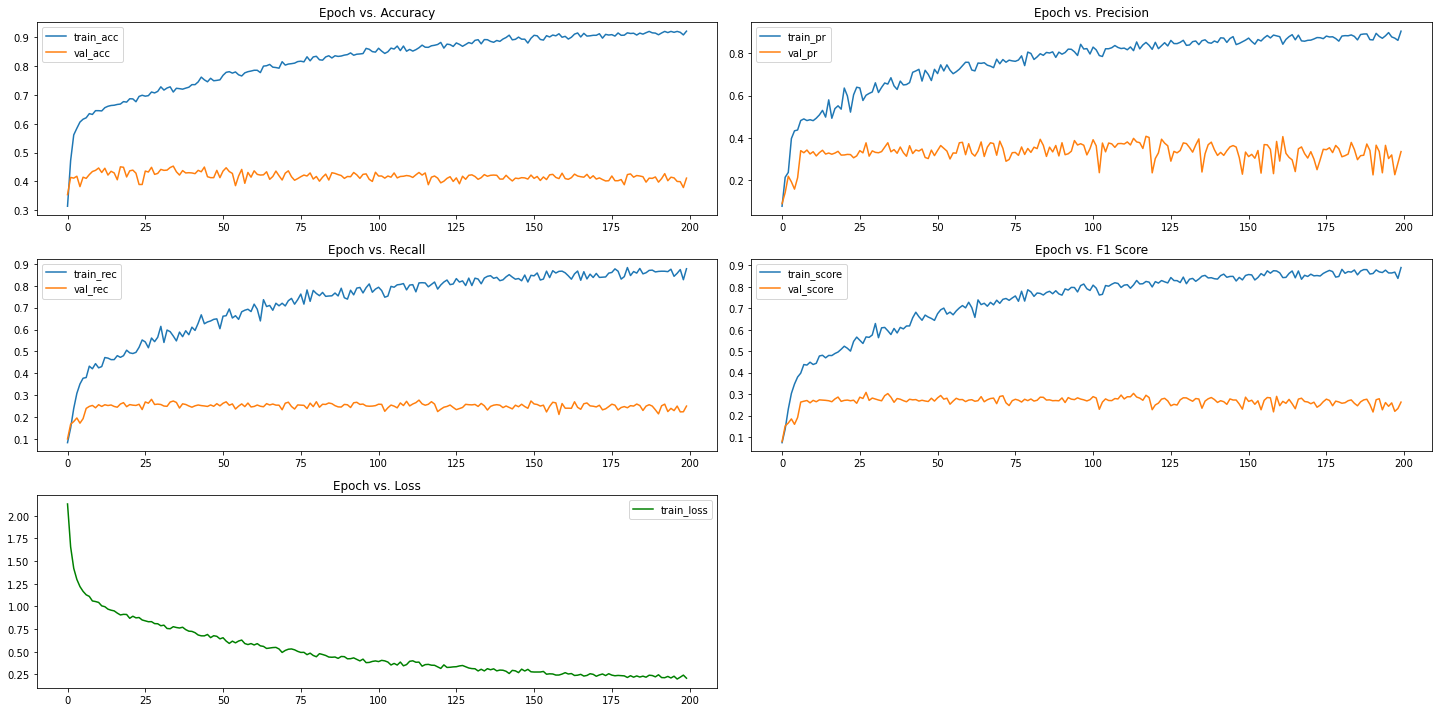

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
df.plot(
    y=["train_acc", "val_acc"],
    title="Epoch vs. Accuracy",
    ax=ax[0, 0],
    legend=True,
)
df.plot(y=["train_pr", "val_pr"], title="Epoch vs. Precision", ax=ax[0, 1])
df.plot(y=["train_rec", "val_rec"], title="Epoch vs. Recall", ax=ax[1, 0])
df.plot(
    y=["train_score", "val_score"],
    title="Epoch vs. F1 Score",
    ax=ax[1, 1],
)
df.plot(y=["train_loss"], title="Epoch vs. Loss", ax=ax[2, 0], color="green")
# Remove the empty subplot
fig.delaxes(ax[2, 1])
plt.tight_layout()
# plt.savefig(f"{save_name}.jpg")
plt.show()